In [261]:
import numpy as np
import pandas as pd
import collections
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.probability import FreqDist
from nltk.sentiment.vader import SentimentIntensityAnalyzer

import spacy
from spacy import displacy
from collections import Counter

from imblearn.over_sampling import SMOTE
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import f1_score, classification_report, confusion_matrix

In [2]:
# TODO: Replace with your Student Number
_STUDENT_NUM = 'A0251445J'

In [3]:
def lemmetize_all(X):
    """ TODO: preprocess data"""
    X_lemmetize = []
    wnl = WordNetLemmatizer()
    for sentence in X:
        tmp = []
        for word, tag in nltk.pos_tag(word_tokenize(sentence)):
            if tag.startswith('NN'):
                tmp.append(wnl.lemmatize(word, pos='n'))
            elif tag.startswith('VB'):
                tmp.append(wnl.lemmatize(word, pos='v'))
            elif tag.startswith('JJ'):
                tmp.append(wnl.lemmatize(word, pos='a'))
            elif tag.startswith('R'):
                tmp.append(wnl.lemmatize(word, pos='r'))
            else:
                tmp.append(word)
            
        X_lemmetize.append(' '.join(tmp))
        
    return X_lemmetize

In [4]:
def add_sentence_length(X):
    return np.array([len(sentence.split()) for sentence in X]).reshape((-1, 1))

In [5]:
def add_polarity(X):
    sid = SentimentIntensityAnalyzer()
    polarity = []
    for sentence in X:
        ss = sid.polarity_scores(sentence)
        polarity.append(list(ss.values()))
    
    return np.array(polarity)

In [6]:
def add_num_count(X):
    num_count = []
    for sentence in X:
        count = 0
        for _, tag in nltk.pos_tag(nltk.word_tokenize(sentence)):
            if tag == 'CD':
                count += 1
        num_count.append(count)

    return np.array(num_count).reshape(-1, 1)

In [7]:
def extract_named_entities_by_types(X_train, X_test):
    count = []
    nlp = spacy.load('en_core_web_sm')
    for sentence in X_train:
        labels = [x.label_ for x in nlp(sentence).ents]
        count.append(Counter(labels))
    for sentence in X_test:
        labels = [x.label_ for x in nlp(sentence).ents]
        count.append(Counter(labels))

    return pd.DataFrame(count).fillna(0)

In [168]:
def most_common_by_type(df, threshold = 40):
    common_list = []
    for label in df['Verdict'].unique():
        tmp = ' '.join(df.loc[df['Verdict'] == label, 'Text'].values)
        tokens = [token.lower() for token in word_tokenize(tmp) if token.isalpha() and 
                token.lower() not in nltk.corpus.stopwords.words('english')]
        common_list.append(FreqDist(tokens).most_common(threshold))

    return common_list

In [8]:
def train_model(model, X_train, y_train, method = 'nn', need_dev = 'False'):
    """ TODO: train your model based on the training data """
        
    if method == 'nn':
        model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
        
        if need_dev == 'True':
            X_train_post, X_dev_post, y_train_post, y_dev_post = train_test_split(
                X_train, y_train, test_size=0.2, random_state=42)
            history = model.fit(
                X_train_post, 
                y_train_post,
                batch_size=512,
                epochs=15,
                validation_data=(X_dev_post, y_dev_post),
            )
        else:
            history = model.fit(
                X_train, 
                y_train,
                batch_size=512,
                epochs=15,
            )
    
    return

In [9]:
def predict(model, X_test, method = 'nn'):
    """ TODO: make your prediction here """
    if method == 'nn':
        y_pred = np.argmax(model.predict(X_test), axis=1) - 1
    return y_pred

In [10]:
def generate_result(test, y_pred, filename):
    """ generate csv file base on the y_pred """
    test['Verdict'] = pd.Series(y_pred)
    test.drop(columns=['Text'], inplace=True)
    test.to_csv(filename, index=False)

In [ ]:
def main():
    """ load train, val, and test data """
    train = pd.read_csv('train.csv')
    X_train = train['Text']
    y_train = train['Verdict']
    
    test = pd.read_csv('test.csv')
    X_test = test['Text']
    # preprocessing
    
    
    model = None  # TODO: Define your model here
    
    model = keras.Sequential(
    [
        layers.Dense(32, activation='relu', input_shape=(X_train_vec.shape[1],)),
        layers.Dropout(0.3),
        layers.Dense(16, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(3, activation='softmax'),
    ])

    # model.summary()
    
    train_model(model, X_train, y_train)
    
#     # test your model
#     y_pred = predict(model, X_train)

    # Use f1-macro as the metric
    score = f1_score(y_train, y_pred, average='macro')
    print('score on validation = {}'.format(score))

    # generate prediction on test data
    y_pred = predict(model, X_test)
    
#     generate_result(test, y_pred, _STUDENT_NUM + ".csv")

In [ ]:
# Allow the main class to be invoked if run as a file.
if __name__ == "__main__":
    main()


In [238]:
train = pd.read_csv('train.csv')
X_train = train['Text']
y_train = train['Verdict']

test = pd.read_csv('test.csv')
X_test = test['Text']

In [217]:
# X_train = lemmetize_all(X_train)
# X_test = lemmetize_all(X_test)

In [239]:
vectorizer = TfidfVectorizer().fit(X_train)
X_train_vec = vectorizer.transform(X_train).toarray()

y_train_dum = pd.get_dummies(y_train)

In [240]:
X_train_vec.shape

(22501, 11424)

In [241]:
# Additional features
scaler = MinMaxScaler()
X_train_vec = np.concatenate((X_train_vec, scaler.fit_transform(add_sentence_length(X_train))), axis=1)

In [242]:
polarity = add_polarity(X_train)
X_train_vec = np.concatenate((X_train_vec, polarity), axis=1)

In [243]:
num_count = add_num_count(X_train)
X_train_vec = np.concatenate((X_train_vec, num_count), axis=1)

In [244]:
data = extract_named_entities_by_types(X_train, X_test)

In [224]:
data[:len(X_train_vec)]

,PERSON,CARDINAL,NORP,GPE,ORG,DATE,FAC,PERCENT,ORDINAL,MONEY,TIME,LOC,WORK_OF_ART,LAW,EVENT,PRODUCT,QUANTITY,LANGUAGE
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22496,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
22497,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
22498,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
22499,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [245]:
X_train_vec = np.concatenate((X_train_vec, data[:len(X_train_vec)]), axis=1)

In [246]:
X_train_vec.shape

(22501, 11448)

In [247]:
reg = keras.regularizers.l2(0.001)
tf.random.set_seed(0)

model = keras.Sequential(
    [
        layers.Dense(128, activation='relu', input_shape=(X_train_vec.shape[1],), kernel_regularizer=reg),
        # layers.Dropout(0.3),
        layers.Dense(64, activation='relu', kernel_regularizer=reg),
        # layers.Dropout(0.3, seed=1),
        layers.Dense(3, activation='softmax'),
    ])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_66 (Dense)            (None, 128)               1465472   
                                                                 
 dense_67 (Dense)            (None, 64)                8256      
                                                                 
 dense_68 (Dense)            (None, 3)                 195       
                                                                 
Total params: 1,473,923
Trainable params: 1,473,923
Non-trainable params: 0
_________________________________________________________________


In [228]:
X_train_post, X_dev_post, y_train_post, y_dev_post = train_test_split(
                X_train_vec, y_train_dum, test_size=0.1, random_state=42)
history = model.fit(
    X_train_post, 
    y_train_post,
    batch_size=512,
    epochs=25,
    validation_data=(X_dev_post, y_dev_post),
)

Epoch 1/25
40/40 [==============================] - 2s 30ms/step - loss: 0.9885 - accuracy: 0.6984 - val_loss: 0.8026 - val_accuracy: 0.7152
Epoch 2/25
40/40 [==============================] - 1s 26ms/step - loss: 0.7278 - accuracy: 0.7449 - val_loss: 0.7180 - val_accuracy: 0.7397
Epoch 3/25
40/40 [==============================] - 1s 25ms/step - loss: 0.6645 - accuracy: 0.7697 - val_loss: 0.6953 - val_accuracy: 0.7468
Epoch 4/25
40/40 [==============================] - 1s 25ms/step - loss: 0.6325 - accuracy: 0.7819 - val_loss: 0.6856 - val_accuracy: 0.7534
Epoch 5/25
40/40 [==============================] - 1s 24ms/step - loss: 0.6096 - accuracy: 0.7955 - val_loss: 0.6863 - val_accuracy: 0.7539
Epoch 6/25
40/40 [==============================] - 1s 25ms/step - loss: 0.5962 - accuracy: 0.8008 - val_loss: 0.6824 - val_accuracy: 0.7583
Epoch 7/25
40/40 [==============================] - 1s 27ms/step - loss: 0.5808 - accuracy: 0.8110 - val_loss: 0.6789 - val_accuracy: 0.7601
Epoch 8/25
40

In [248]:
history = model.fit(
    X_train_vec, 
    y_train_dum,
    batch_size=512,
    epochs=10,
)

Epoch 1/10
44/44 [==============================] - 2s 34ms/step - loss: 0.9918 - accuracy: 0.6768
Epoch 2/10
44/44 [==============================] - 1s 30ms/step - loss: 0.7179 - accuracy: 0.7474
Epoch 3/10
44/44 [==============================] - 1s 30ms/step - loss: 0.6540 - accuracy: 0.7706
Epoch 4/10
44/44 [==============================] - 1s 29ms/step - loss: 0.6187 - accuracy: 0.7914
Epoch 5/10
44/44 [==============================] - 1s 31ms/step - loss: 0.5960 - accuracy: 0.8064
Epoch 6/10
44/44 [==============================] - 1s 31ms/step - loss: 0.5787 - accuracy: 0.8154
Epoch 7/10
44/44 [==============================] - 1s 30ms/step - loss: 0.5628 - accuracy: 0.8225
Epoch 8/10
44/44 [==============================] - 1s 30ms/step - loss: 0.5513 - accuracy: 0.8305
Epoch 9/10
44/44 [==============================] - 1s 31ms/step - loss: 0.5433 - accuracy: 0.8357
Epoch 10/10
44/44 [==============================] - 1s 29ms/step - loss: 0.5326 - accuracy: 0.8443


In [249]:

# X_test = lemmetize_all(X_test)
test = pd.read_csv('test.csv')

X_test_vec = vectorizer.transform(X_test).toarray()
X_test_vec = np.concatenate((X_test_vec, scaler.transform(add_sentence_length(X_test))), axis=1)

polarity = add_polarity(X_test)
X_test_vec = np.concatenate((X_test_vec, polarity), axis=1)

num_count = add_num_count(X_test)
X_test_vec = np.concatenate((X_test_vec, num_count), axis=1)

X_test_vec = np.concatenate((X_test_vec, data[len(X_train_vec):]), axis=1)

In [250]:
model.predict(X_test_vec)

33/33 [==============================] - 0s 2ms/step


array([[0.6870745 , 0.2787907 , 0.03413477],
       [0.08123826, 0.01512453, 0.90363723],
       [0.6910736 , 0.15414338, 0.154783  ],
       ...,
       [0.9944689 , 0.004495  , 0.00103609],
       [0.6937552 , 0.17277078, 0.1334739 ],
       [0.9374259 , 0.04111432, 0.02145977]], dtype=float32)

In [251]:
y_pred = np.argmax(model.predict(X_test_vec), axis=1) - 1

33/33 [==============================] - 0s 2ms/step


In [252]:
test = pd.read_csv('test.csv')
generate_result(test, y_pred, _STUDENT_NUM + ".csv")

In [197]:
# y_pred = model.predict(X_train_vec)
y_dev = np.argmax(y_dev_post.to_numpy(), axis=1) - 1
y_dev_pred = np.argmax(model.predict(X_dev_post), axis=1) - 1

71/71 [==============================] - 0s 2ms/step


In [198]:
print(classification_report(y_dev, y_dev_pred))

              precision    recall  f1-score   support

          -1       0.85      0.87      0.86      1451
           0       0.45      0.29      0.35       250
           1       0.64      0.69      0.66       550

    accuracy                           0.76      2251
   macro avg       0.64      0.62      0.62      2251
weighted avg       0.75      0.76      0.76      2251



In [209]:
confusion_matrix(y_dev, y_dev_pred)

array([[1268,   49,  134],
       [  97,   72,   81],
       [ 130,   40,  380]], dtype=int64)

In [ ]:
vectorizer = CountVectorizer()
vectorized_texts = vectorizer.fit_transform(X_train)

In [ ]:
vectorized_texts

<22501x11424 sparse matrix of type '<class 'numpy.int64'>'
	with 335979 stored elements in Compressed Sparse Row format>

In [ ]:
classifier = MultinomialNB()
classifier.fit(vectorized_texts, y_train)

MultinomialNB()

In [ ]:
y_pred = classifier.predict(vectorized_texts)

In [ ]:
score = f1_score(y_train, y_pred, average='macro')

In [ ]:
score

0.7175508264672326

In [ ]:
y_pred = classifier.predict(vectorizer.transform(X_test))

In [212]:
vectorizer = TfidfVectorizer()
vectorized_texts = vectorizer.fit_transform(X_train)

In [213]:
classifier = MultinomialNB()
classifier.fit(vectorized_texts, y_train)

MultinomialNB()

In [214]:
classifier.score(vectorized_texts, y_train)

0.7514332696324608

In [215]:
y_pred = classifier.predict(vectorizer.transform(X_test))

In [216]:
test = pd.read_csv('test.csv')
generate_result(test, y_pred, _STUDENT_NUM + ".csv")

In [178]:
class_polarity = collections.defaultdict(list)
class_polarity[-1] = [0, 0, 0, 0]
class_polarity[0] = [0, 0, 0, 0]
class_polarity[1] = [0, 0, 0, 0]

sid = SentimentIntensityAnalyzer()

for i in range(len(X_train)):
    ss = sid.polarity_scores(X_train[i])
    class_polarity[y_train[i]][0] += ss['neg']
    class_polarity[y_train[i]][1] += ss['neu']
    class_polarity[y_train[i]][2] += ss['pos']
    class_polarity[y_train[i]][3] += ss['compound']

<AxesSubplot:>

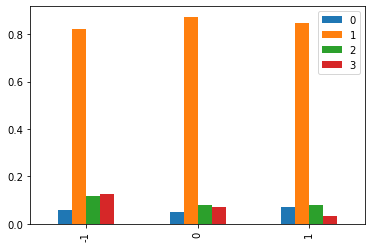

In [197]:
pd.DataFrame.from_dict(class_polarity, orient='index').div(y_train.value_counts(), axis=0).plot.bar()

In [136]:
nltk.pos_tag(nltk.word_tokenize("Storwerqw"))

[('Storwerqw', 'NN')]

In [104]:
lr_clf = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000)

In [105]:
X_train_vec.shape

(22501, 5006)

In [ ]:
lr_clf.fit(X_train_vec, y_train)

In [107]:
y_pred = lr_clf.predict(X_train_vec)

In [113]:
f1_score(y_train, y_pred, average='macro')

0.7048283674184939

In [154]:
tmp = ' '.join(train.loc[train['Verdict'] == -1, 'Text'].values)
tokens = [token.lower() for token in word_tokenize(tmp) if token.isalpha() and 
          token.lower() not in nltk.corpus.stopwords.words('english')]

In [169]:
common_list = most_common_by_type(train)

In [172]:
len(list(set([t[0] for label_common in common_list for t in label_common ])))

70

In [270]:
# Oversample the minority class
vectorizer = CountVectorizer()
X_train_counts = vectorizer.fit_transform(X_train)

oversampler = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = oversampler.fit_resample(X_train_counts, y_train)
y_train_dum2 = pd.get_dummies(y_train_resampled)

In [272]:
reg = keras.regularizers.l2(0.001)
tf.random.set_seed(0)

model = keras.Sequential(
    [
        layers.Dense(128, activation='relu', input_shape=(X_train_resampled.shape[1],), kernel_regularizer=reg),
        # layers.Dropout(0.3),
        layers.Dense(64, activation='relu', kernel_regularizer=reg),
        # layers.Dropout(0.3, seed=1),
        layers.Dense(3, activation='softmax'),
    ])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

X_train_post, X_dev_post, y_train_post, y_dev_post = train_test_split(
                X_train_resampled.toarray(), y_train_dum2, test_size=0.1, random_state=42)
history = model.fit(
    X_train_post, 
    y_train_post,
    batch_size=512,
    epochs=25,
    validation_data=(X_dev_post, y_dev_post),
)


Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_75 (Dense)            (None, 128)               1462400   
                                                                 
 dense_76 (Dense)            (None, 64)                8256      
                                                                 
 dense_77 (Dense)            (None, 3)                 195       
                                                                 
Total params: 1,470,851
Trainable params: 1,470,851
Non-trainable params: 0
_________________________________________________________________
Epoch 1/25
78/78 [==============================] - 5s 52ms/step - loss: 0.9672 - accuracy: 0.6393 - val_loss: 0.8188 - val_accuracy: 0.7038
Epoch 2/25
78/78 [==============================] - 4s 48ms/step - loss: 0.7648 - accuracy: 0.7280 - val_loss: 0.7660 - val_accuracy: 0.7224
Epoch 3/25
78/78 [=======